In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
training_set = pd.read_csv('aug_train.csv')
x_test = pd.read_csv('aug_test.csv')
y_test = np.load('jobchange_test_target_values.npy')

Drop enrolle_id because it is irrelevant to predict the target. We'll also drop city because a city can be described by its city_development_index.

In [3]:
training_set.drop(['enrollee_id','city'],axis=1,inplace=True)
x_test.drop(['enrollee_id','city'],axis=1,inplace=True)

In [4]:
x_train = training_set.drop('target',axis=1)
y_train = training_set['target'].astype(int)

## Exploratory Data Analysis

### Missing Values

In [5]:
x_train.isnull().sum()

city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
dtype: int64

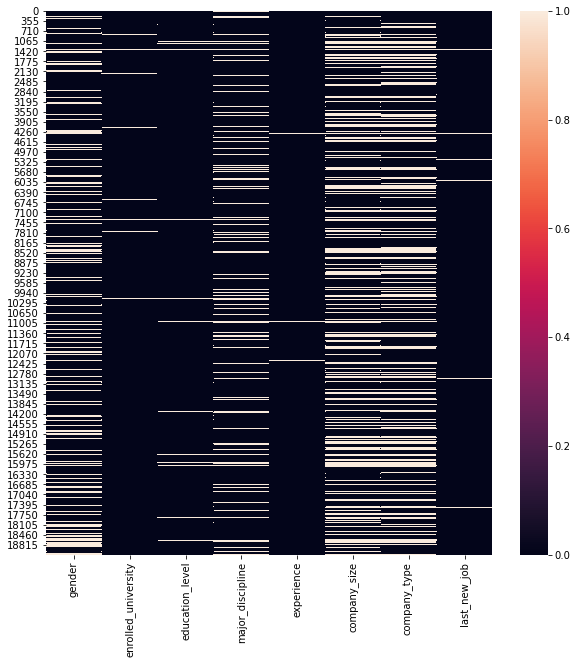

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(x_train.drop(['city_development_index','relevent_experience','training_hours'],axis=1).isnull())
plt.show()

### City Development Index Boxplot

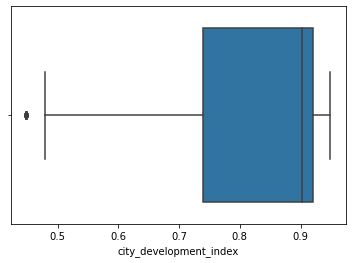

In [7]:
sns.boxplot(x = x_train['city_development_index'])
plt.show()

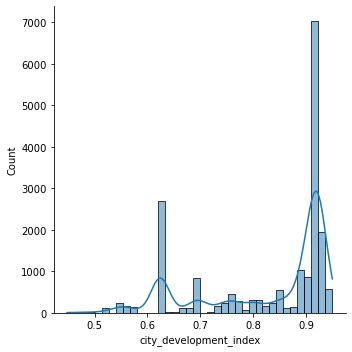

In [8]:
sns.displot(x_train['city_development_index'],kde=True)
plt.show()

### Training Hours

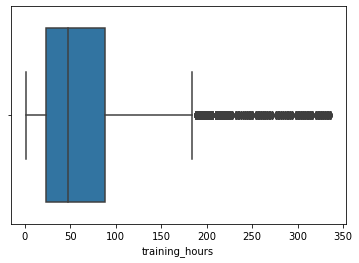

In [9]:
sns.boxplot(x = x_train['training_hours'])
plt.show()

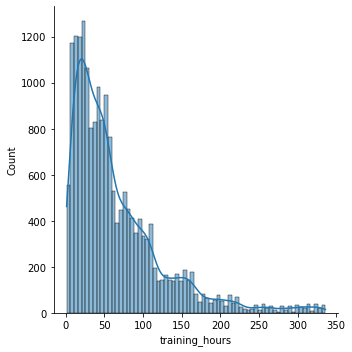

In [10]:
sns.displot((x_train['training_hours']),kde=True)
plt.show()

In [11]:
x_train.nunique()

city_development_index     93
gender                      3
relevent_experience         2
enrolled_university         3
education_level             5
major_discipline            6
experience                 22
company_size                8
company_type                6
last_new_job                6
training_hours            241
dtype: int64

Due to a lot of unique values in experience column, we will use binary encoder to encode this column.

Data types:
- Categorical nominal: gender, relevent_experience, enrolled_university, major_discipline, company_type, last_new_job, experience
- Categorical ordinal: education_level, company_size
- Numerical: city_development_index, training_hours

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder

Preprocessing:
- Simple Imputer & Binary Encoder: experience, city
- SimpleImputer & OneHotEncoder: enrolled_university, last_new_job, relevent_experience, gender, major_discipline, company_type
- SimpleImputer & OrdinalEncoder: education_level, company_size
- RobustScaler: training_hours (too many outlier)

In [13]:
binary_pipe = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('binary',ce.BinaryEncoder())
])

simple_onehot = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(drop='first'))
])

simple_ord = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('ordinal',OrdinalEncoder(categories=[['Primary School','High School','Graduate','Masters','Phd'],
                              ['<10','10/49','50-99','100-500','500-999','1000-4999','5000-9999','10000+']]))
])

transformer = ColumnTransformer([
    ('binary',binary_pipe,['experience']),
    ('simple_onehot',simple_onehot,['enrolled_university',
                                    'last_new_job',
                                    'relevent_experience',
                                    'gender',
                                    'major_discipline',
                                    'company_type']),
    ('simple_ordinal',simple_ord,['education_level','company_size']),
    ('scaling',RobustScaler(),['training_hours'])
],remainder='passthrough')

## Model

- TP: Candidate predicted will change his/her job and actually changed his/her job
- TN: Candidate predicted will not change his/her job and actually did not change his/her job
- FP: Candidate predicted will change his/her job but actually did not change his/her job
- FN: Candidate predicted will not change his/her job but actually changed his/her job

We want to minimize FP to reduce the cost and time given to a candidate that was actually didn't want to change his/her job. Thus in this problem, we'll use precision metric to evaluate models.

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score,StratifiedKFold

In [15]:
tree = DecisionTreeClassifier(max_depth=3)
knn = KNeighborsClassifier(n_neighbors=5)
logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier()

In [16]:
models = [tree,knn,logreg,rf]
cv_mean = []
cv_std = []

for i in models:
    skfold = StratifiedKFold(5)
    estimator = Pipeline([
        ('preprocess',transformer),
        ('model',i)
    ])
    cv_score = cross_val_score(estimator, x_train,y_train,cv=skfold,scoring='precision')
    cv_mean.append(cv_score.mean())
    cv_std.append(cv_score.std())

pd.DataFrame({
    'model':['DT','KNN','Logreg','RF'],
    'prec_mean':cv_mean,
    'prec_std':cv_std
})

,model,prec_mean,prec_std
0,DT,0.588360,0.013551
1,KNN,0.423476,0.017788
2,Logreg,0.572064,0.006666
3,RF,0.542359,0.018417


From the above result, DecisionTree model has the highest recall score with second lowest deviation. Thus we are going to use decision tree model.

## Model Improvement and Hyperparameter Tuning

### Imbalance Classification

In [17]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [18]:
y_train.value_counts()

0    14381
1     4777
Name: target, dtype: int64

Because the dataset is imbalance, we need to undersample or oversample the dataset. Below, we will compare SMOTE and NearMiss imbalance classification method.

In [34]:
dt = DecisionTreeClassifier(max_depth=5,class_weight='balanced',random_state=10)
estimator = Pipeline([
        ('preprocess',transformer),
        ('model',dt)
])
estimator.fit(x_train,y_train)
y_pred = estimator.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.84      0.84      1553
         1.0       0.57      0.59      0.58       576

    accuracy                           0.77      2129
   macro avg       0.71      0.71      0.71      2129
weighted avg       0.77      0.77      0.77      2129



In [33]:
dt = DecisionTreeClassifier(max_depth=5,random_state=10)
resample = [SMOTE(),NearMiss()]
for i in resample:
    estimator = Pipeline([
        ('preprocess',transformer),
        ('resampling',i),
        ('model',dt)
    ])
    estimator.fit(x_train,y_train)
    y_pred = estimator.predict(x_test)
    print(i)
    print(classification_report(y_test,y_pred))
    print('\n')

SMOTE()
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84      1553
         1.0       0.56      0.57      0.56       576

    accuracy                           0.76      2129
   macro avg       0.70      0.70      0.70      2129
weighted avg       0.76      0.76      0.76      2129



NearMiss()
              precision    recall  f1-score   support

         0.0       0.83      0.51      0.63      1553
         1.0       0.35      0.72      0.47       576

    accuracy                           0.57      2129
   macro avg       0.59      0.62      0.55      2129
weighted avg       0.70      0.57      0.59      2129





From the result above, we can see that both SMOTE and NearMiss method gives smaller precision than class_weight method. Thus class_weight method is used.

### Hyperparameter Tuning

In [35]:
dt = DecisionTreeClassifier(class_weight='balanced',random_state=10)
estimator = Pipeline([
        ('preprocess',transformer),
        ('model',dt)
    ])
estimator.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('binary',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('binary', BinaryEncoder())]),
                                    ['experience']),
                                   ('simple_onehot',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['enrolled_university', 'last_new_job',
                                     'releve...
                                   ('simple_ordinal',
                                

In [36]:
hyperparam_space = {
    'model__criterion':['gini','entropy'],
    'model__max_depth':[3,4,5,6,7,8,9],
}

In [37]:
skfold = StratifiedKFold(5)
grid = GridSearchCV(
    estimator,
    cv = skfold,
    param_grid=hyperparam_space,
    scoring='precision',
    n_jobs=-1
)

In [38]:
grid.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('binary',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('binary',
                                                                                          BinaryEncoder())]),
                                                                         ['experience']),
                                                                        ('simple_onehot',
                                                                         Pipel

In [39]:
grid.best_params_

{'model__criterion': 'entropy', 'model__max_depth': 5}

In [40]:
y_pred = grid.best_estimator_.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84      1553
         1.0       0.57      0.59      0.58       576

    accuracy                           0.77      2129
   macro avg       0.71      0.71      0.71      2129
weighted avg       0.77      0.77      0.77      2129



In [41]:
grid.best_estimator_[1].feature_importances_

array([0.00000000e+00, 0.00000000e+00, 9.25830256e-04, 0.00000000e+00,
       4.47801911e-19, 0.00000000e+00, 0.00000000e+00, 4.33726800e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.06840695e-03,
       2.12130361e-03, 1.54119581e-02, 2.32416095e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.16762145e-04, 1.86016207e-03, 0.00000000e+00, 0.00000000e+00,
       2.18597757e-03, 0.00000000e+00, 1.61615377e-03, 2.61220728e-01,
       8.94201520e-03, 6.57033861e-01])

In [42]:
features = grid.best_estimator_[0].transformers_[0][1][1].get_feature_names()+\
            list(grid.best_estimator_[0].transformers_[1][1][1].get_feature_names())+\
            grid.best_estimator_[0].transformers_[2][2]+\
            ['training_hours','city_development_index']

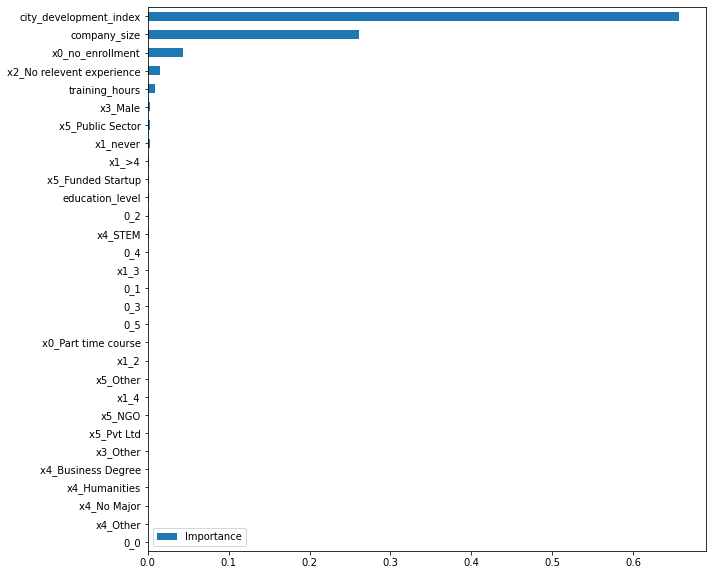

In [43]:
pd.DataFrame({'Importance':grid.best_estimator_[1].feature_importances_},
            index=features).sort_values(by='Importance',ascending=True).plot(kind='barh',figsize=(10,10))
plt.show()

From the plot above, top 5 features that affect the candidate decision are:
* city_development_index
* company size
* enrollment_university
* relevent_experience
* training_hours

Here, we can see that the precision score isnt improving. Thus, we will use Gradient Boosting Method to increase it.

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

In [67]:
model = GradientBoostingClassifier(max_depth=5,random_state=10)
estimator = Pipeline([
    ('preprocess',transformer),
    ('model',model)
])

estimator.fit(x_train,y_train)
y_pred = estimator.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85      1553
         1.0       0.60      0.44      0.51       576

    accuracy                           0.77      2129
   macro avg       0.71      0.66      0.68      2129
weighted avg       0.75      0.77      0.76      2129



As shown above, the precision score is improved from 0.57 to 0.6.